In [1]:
import numpy as np
import matplotlib.pyplot as plt

import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from trainer import Trainer
from optimizer import Adam

from util import *
from dataset import ptb

# Chapter 5 순환 신경망(RNN)

지금까지 본 신경망들은 흐름이 단방향인 **feed forward 신경망**이었다. feed forward 신경망은 구성이 단순해서 이해하기 쉽지만, 시계열 데이터의 패턴을 충분히 학습할 수 없다. 그래서 순환 신경망(Recurrent Neural Network, RNN)이 나왔다.

이번 장에서는 피드포워드 신경망의 문제점을 지적하고, RNN이 대안이 될 수 있는 이유에 대해 다뤄본다. 또한, RNN 구조를 알아보고 파이썬으로 구현해볼 것이다.

## 5.1 확률과 언어 모델

이번 장에서는 word2vec을 복습해보고, 자연어에 관한 현상을 '확률'로 기술해보고, 언어를 확률로 다루는 '언어 모델'에 대해 설명해본다.

### 5.1.1 word2vec을 확률 관점에서 바라보자

$w_1, w_2, ..., w_T$라는 단어들의 sequence로 구성된 corpus가 있을 때, $t$번째 단어를 target, $t-1, t+1$ 번째 단어를 'contexts'라고 하면, CBOW 모델의 목표는 $w_{t-1}$과 $w_{t+1}$로부터 $w_t$를 추측하는 것이다.

<img src="./deep_learning_2_images/fig 5-1.png" width="60%">

이때, $w_{t-1}$과 $w_{t+1}$이 주어졌을 때, target이 $w_t$가 될 확률은 다음과 같이 나타낼 수 있다.

$$
P(w_t|w_{t-1}, w_{t+1})
$$

CBOW 모델은 위 확률을 반환한다. (책의 표현을 빌리면 "사후 확률을 모델링합니다.")

context를 왼쪽 윈도우로 한정해보면, 다음 확률이 나온다. (왼쪽 윈도우로 한정짓는다는 거는 아래 그림 상황을 본다는 의미이다.)

<img src="./deep_learning_2_images/fig 5-2.png" width="60%">

$$
P(w_t|w_{t-2}, w_{t-1})
$$

위 확률을 CBOW 모델의 cross-entropy loss에 적용하면 다음 수식이 나온다

$$
L = -\log P(w_t|w_{t-2}, w_{t-1})
$$

CBOW 모델의 학습은 loss function을 최소화하는 가중치 매개변수를 찾는 과정이다. CBOW 모델의 원래 목적인 "context를 이용해 target을 찾는다"를 학습하다 보면, 부산물로 단어의 의미가 인코딩된 '단어의 분산 표현'을 가중치 매개변수로부터 얻을 수 있다.

CBOW 모델의 원래 기능인 "context를 이용해 target을 찾기"와 확률 $P(w_t|w_{t-2}, w_{t-1})$는 '언어 모델'에서 등장한다.

### 5.1.2 언어 모델

**언어 모델(Language Model)**은 특정 단어 sequence에 대해, 그 sequence가 일어날 확률을 반환한다.

언어 모델을 수식적으로 나타내보자. $w_1, w_2, ..., w_m$이라는 m개의 단어로 이루어진 문장이 있을 때, 이 단어들이 순서대로 출현할 확률은 동시확률 $P(w_1, w_2, ..., w_m)$으로 나타낼 수 있다.

이 동시확률은 다음과 같이 분해할 수 있다.

$$
\begin{aligned}
    P(w_1, w_2, ..., w_m) &= P(w_m|w_1, w_2, ..., w_{m-1})P(w_m|w_1, w_2, ..., w_{m-1}) \\
                          &\quad \cdots P(w_3|w_1, w_2)P(w_2|w_1) \\
                          &= \prod_{t=1}^{m} P(w_t|w_1, ..., w_{t-1})
\end{aligned}
$$

위 식의 결과는 아래 확률의 곱셈정리로부터 유도된다. 확률의 곱셈 정리는 '$A$와 $B$가 모두 일어날 확률은 $B$가 일어날 확률과 $B$가 일어난 후 $A$가 일어날 확률을 곱한 값과 같다'이다. 

$$
P(A, B) = P(A|B)P(B)
$$

우리의 목표인 동시확률 $P(w_1, w_2, ..., w_m)$을 사후확률의 곱인 $\prod P(w_t|w_1, ..., w_{t-1})$로 나타냈다. 여기서 사후확률 $P(w_t|w_1, ..., w_{t-1})$은 target 단어보다 왼쪽에 있는 모든 단어를 context로 했을 때의 확률과 동일하다.

<img src="./deep_learning_2_images/fig 5-3.png" width="60%">

우리의 목표는 이제 $P(w_t|w_1, ..., w_{t-1})$를 얻는 것이다. 이 확률을 구하면 언어 모델의 동시확률을 구할 수 있기 때문이다

### 5.1.3 CBOW 모델을 언어 모델로?

word2vec의 CBOW 모델을 언어 모델에 적용한다면, context의 크기를 특정 값으로 한정지은 후, 근사적으로 나타낼 수 있다.

$$
P(w_1, w_2, ..., w_m) = \prod_{t=1}^{m} P(w_t|w_1, ..., w_{t-1}) \approx \prod_{t=1}^{m} P(w_t|w_{t-2}, w_{t-1})
$$

> NOTE: 위 수식에서 CBOW 모델은 **'직전 두 개의 단어에 의해 다음 단어가 결정되는'** 모델이므로, **2 step markov chain**이라 볼 수 있다.

하지만 근사를 할 수 있다고 해도, 결국 context의 길이가 한정되어 있다. 또한, CBOW 모델에서는 context 안의 단어 순서들이 무시된다는 한계가 있다. (CBOW의 약어 Continuous Bag-Of-Word에서 bag라는 표현에는 순서는 무시된다는 뜻 또한 같이 있다.). 아래 그림에서 CBOW 모델을 보면, context 속 단어 벡터들이 은닉층에서 더해지기 때문에, 단어 사이의 순서는 무시되는 것을 알 수 있다. 

<img src="./deep_learning_2_images/fig 5-5.png" width="60%">

위 그림의 오른쪽처럼 은닉층에서 두 단어를 연결해 맥락을 고려할 수 있도록 만들 수 있지만(Neural Probabilistic Language Model이 이 전략을 사용한다), 이는 매개변수가 늘어난다는 점에서 비효율적이다. 이때 RNN이 등장한다.

> WARNING: 실제로는 RNN을 이용한 언어 모델이 2010년에 나오고, word2vec은 2013년에 나왔다. word2vec은 단어의 분산 표현을 얻을 목적으로 고안되어서 실제로 언어 모델에서 사용되지는 않는다. 이 책에서도 RNN의 매력을 보여주기 위해서 억지로 word2vec의 CBOW 모델로 언어 모델을 만들어 본 것이다.

## 5.2 RNN이란

### 5.2.1 순환하는 신경망

순환하기 위해서는 '닫힌 경로' 혹은 '순환하는 경로'가 필요하다. '순환하는 경로'가 있어야 데이터가 같은 장소를 반복해서 지나가고, 데이터가 순환하면서 정보가 갱신된다.

RNN에는 데이터가 순환하는 경로가 있다. 데이터가 순환되기 때문에 과거의 정보를 기억하는 것도 가능하고, 최신 데이터로 갱신되는 것도 가능하다. RNN 계층은 다음과 같이 표현할 수 있다.

<img src="./deep_learning_2_images/fig 5-7.png" width="60%">

위에서 보이듯, RNN 계층은 순환하는 경로가 있다. 그리고 $\mathbf{x}_t$를 입력받는데, 여기서 $t$는 시각을 의미한다. 이는 시계열 데이터 $(\mathbf{x}_0, \mathbf{x}_1, \cdots, \mathbf{x}_t, \cdots)$가 RNN 계층에 들어오는 것을 나타낸다. 입력에 대응한 시계열 출력 $(\mathbf{h}_0, \mathbf{h}_1, \cdots, \mathbf{h}_t, \cdots)$도 나온다. 

입력 $\mathbf{x}_t$는 벡터라고 가정한다. 문장을 다룬다고 할 때, 각 단어의 분산 표현이 $\mathbf{x}_t$가 되고, 분산 표현이 RNN 계층에 입력된다.

### 5.2.2 순환 구조 펼치기

RNN 구조를 펼치면 우리가 알고 있는 feed forward 신경망처럼 보인다.

<img src="./deep_learning_2_images/fig 5-8.png" width="60%">

> NOTE: 시계열 데이터는 시간 방향으로 데이터가 나열된다. 이때, 시계열 데이터의 인덱스를 가리킬 때는 '시각'이라는 용어를 사용한다.

RNN 계층은 계층 입력과 이전 시각의 출력을 바탕으로 현재 출력을 계산한다. 이때 계산식은 다음과 같다.

$$
\mathbf{h}_t = \tanh (\mathbf{h}_{t-1}\mathbf{W}_{\mathbf{h}}+\mathbf{x}_t \mathbf{W}_{\mathbf{x}} + \mathbf{b})
$$

RNN에는 입력을 출력으로 변환하기 위한 가중치 $\mathbf{W}_{\mathbf{x}}$와, 이전 출력을 다음 출력으로 변환하기 위한 가중치 $\mathbf{W}_{\mathbf{h}}$, 두 개의 가중치가 있다. $\mathbf{b}$는 편향이다. 여기서 $\mathbf{h}, \mathbf{x}$는 행벡터이다.

행렬곱 연산 뒤에 $\tanh$ 함수 거쳐 최종 출력이 나온다. 이 출력은 다음 출력을 만들 때도 사용되고, 현재 시각의 출력이기도 하다.

현재의 출력($\mathbf{h}_t$)은 한 시각 이전의 출력($\mathbf{h}_{t-1}$)을 바탕으로 나온다. 이를 다르게 보면, RNN은 $\mathbf{h}$라는 '상태(state)'를 가지고 있고, 위의 식을 통해 갱신된다고 볼 수 있다. 그래서 RNN 계층을 '상태를 가지는 계층', '메모리가 있는 계층'이라고 말한다.

> NOTE: 많은 문헌에서 RNN의 출력 $\mathbf{h}$를 hidden state 또는 hidden state vector라고 부른다.

### 5.2.3 BPTT

RNN 계층을 펼친 사진을 보면, 일반적인 feed forward 신경망처럼 back propagation을 통해 학습할 수 있다는 것을 알 수 있다. 이때 오차역전파법을 **BPTT(BackPropagation Through Time)**라고 부른다.

<img src="./deep_learning_2_images/fig 5-10.png" width="60%">

BPTT를 이용해 RNN을 학습시키면 될 것 같지만, 긴 시계열 데이터를 학습 할 때 문제를 해결해야 한다. 시계열 데이터가 길어질 수록 컴퓨팅 자원이 증가하기 때문이다. BPTT는 이전 시각의 데이터를 가지고 있어야 하기 때문에 시계열 데이터가 길어질수록 메모리 사용량 또한 많아진다.

### 5.2.4 Truncated BPTT

큰 시계열 데이터를 다룰 때는 역전파 단계를 적당히 끊는다. 너무 길어진 신경망을 적당히 끊어서 작은 신경망 여러개로 자른 다음, 작은 신경망에서 오차역전파법을 수행하는 기법을 **Truncated BPTT**라고 부른다.

<img src="./deep_learning_2_images/fig 5-11.png" width="60%">


Truncated BPTT를 사용하는 이유는 일반적인 BPTT를 이용하면 큰 시계열 데이터를 다룰 때 컴퓨팅 자원 문제도 있지만, 계층이 길어질수록 gradient vanishing 문제도 발생하기 때문이다. 

여기서 주의할 점은 역전파의 연결만 끊는 것이지, 순전파는 그대로 유지해야 한다는 점이다. RNN을 학습시킬 때는 데이터를 sequential하게 입력해야 한다.

Truncated BPTT의 전체 흐름은 다음과 같다.

1) 첫 번째 블록 입력 데이터 $\mathbf{x}_0, \cdots , \mathbf{x}_9$를 RNN 계층에 제공한다.
2) 첫 번째 블록의 오차역전파법을 수행한다.

<img src="./deep_learning_2_images/fig 5-12.png" width="60%">

3) 두 번째 블록 입력 데이터 $\mathbf{x}_10, \cdots , \mathbf{x}_19$를 RNN 계층에 제공한다. 이때, 이전 블록의 hidden state $\mathbf{h}_9$를 같이 주어서 순전파의 흐름은 끊기지 않도록 해야 한다.
4) 두 번째 블록의 오차역전파법을 수행한다.

<img src="./deep_learning_2_images/fig 5-13.png" width="60%">

5) 이 흐름을 반복한다.

<img src="./deep_learning_2_images/fig 5-14.png" width="60%">

### 5.2.5 Truncated BPTT의 미니배치 학습

지금까지 Truncated BPTT에서는 미니배치 크기가 1인 경우에 대해 생각했다. 미니배치 학습을 수행할 때도 데이터를 순서대로 제공해야 한다. 

길이가 1000인 시계열 데이터에서, 시각의 길이를 10 단위로 Truncated BPTT를 수행할 때, 미니 배치 크기를 두 개로 구성한다고 하면, 첫 번째 미니 배치 데이터는 시각이 0인 데이터부터 순서대로 제공하고, 두 번째 미니 배치 데이터는 시각이 500인 데이터부터 순서대로 제공한다. 이를 그림으로 정리하면 다음과 같다.

<img src="./deep_learning_2_images/fig 5-15.png" width="60%">

미니배치 학습을 수행할 때는 "각 미니배치의 시작 위치를 offset으로 옮겨준 후 순서대로 데이터를 제공"하면 된다. 데이터를 입력하다가 끝에 도달하면 다시 처음부터 입력하면 된다.

데이터 제공 방법을 정리하면 다음 두 사항을 지키면 된다
- 데이터를 순서대로 제공하기
- 미니배치별로 데이터를 제공하는 시작 위치를 옮기기

## 5.3 RNN 구현

우리가 구현해야 할 계층은 다음 두 계층이다.

- RNN 계층: 한 시각에서 RNN의 순전파, 역전파를 처리하는 계층
- Time RNN 계층: T개 단계분의 RNN 작업을 한꺼번에 처리하는 계층

<img src="./deep_learning_2_images/fig 5-17.png" width="60%">

### 5.3.1 RNN 계층 구현

RNN의 순전파 식은 다음과 같다.

$$
\mathbf{h}_t = \tanh (\mathbf{h}_{t-1}\mathbf{W}_{\mathbf{h}}+\mathbf{x}_t \mathbf{W}_{\mathbf{x}} + \mathbf{b})
$$

여기에 미니배치를 고려해야 하니, $\mathbf{x}_t, \mathbf{h}_t$에는 각 샘플 데이터를 행 방향에 저장한다. 미니배치 크기를 $N$, 입력 벡터 차원 수를 $D$, hidden state 차원수가 $H$라면, 위 순전파 식에서 행렬의 형상을 다음과 같이 나타낼 수 있다.

<img src="./deep_learning_2_images/fig 5-18.png" width="60%">

여담: parameter를 따로 분리해서 모아놓는 게, optimizer를 따로 만들 수 있어서 유리한 구조이다. gradient랑 거기에 맞는 weight를 주면 그에 맞춰서 계산할 수 있으니까. pytorch에서도 optimizer에 network의 parameter를 따로 주니까. 

In [2]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/time_layers.py
License: MIT License
Accessed: 2024-11-21

Modified to work on jupyter notebook
------------------------------------------------------------
"""

from np import * 
from layers import *
from functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        
        # 순전파 수식을 그대로 구현했다
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)    # tanh의 역전파
        db = np.sum(dt, axis=0)             # b(repeat 노드)의 역전파
        dWh = np.dot(h_prev.T, dt)          # Wh (matmul 노드)의 역전파
        dh_prev = np.dot(dt, Wh.T)          # h_prev (matmul 노드)의 역전파
        dWx = np.dot(x.T, dt)               # Wx (matmul 노드)의 역전파
        dx = np.dot(dt, Wx.T)               # x (matmul 노드)의 역전파

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

RNN의 역전파는 RNN 순전파의 계산 그래프를 보면 쉽게 파악할 수 있다. 편향 $\mathbf{b}$에는 Repeat 노드가 사용되었다. 

<img src="./deep_learning_2_images/fig 5-19.png" width="60%">

역전파는 각각의 노드에 해당하는 역전파를 수행해주면 구할 수 있다.

<img src="./deep_learning_2_images/fig 5-20.png" width="60%">

덧셈 노드는 들어온 기울기를 분배하고, Repeat 노드는 들어온 기울기들을 더한다.

matmul 노드의 역전파는 다음과 같다.

<img src="./img/memo-5-3-1-matmul-node.jpg" width="50%">

위 계산 그래프에 적용하면 다음과 같이 정리해볼 수 있다.

<img src="./img/memo-5-3-1-backprop.jpg" width="60%">

### 5.3.2 Time RNN 계층 구현

책하고 코드를 같이 보면서 이해하는 게 더 빠르게 이해하는 방법인거 같다.

책의 그림에서는 펼쳐져서 마치 여러개를 구현한 것처럼 보이지만, 실제로는 동일한 parameter를 이용해서 반복되게 구현되어 있다. 혼동하지 말자. 

<img src="./deep_learning_2_images/fig 5-24.png" width="60%">

Time RNN을 왜 구현하는가에 대한 고민을 해봤고, 다음 결론을 냈다.

- Time RNN의 입력 크기만큼 순서대로 시계열 데이터가 들어간다.
- 순전파시에 Time RNN의 stateful이 True이면, Time RNN은 이전 hidden state를 저장하고 있다가 순전파 시에 활용하니, 결과적으로 순전파 시에는 신경망이 연결되어 있다.
- 역전파시에는 Time RNN 단위로 역전파가 이루어지므로, Truncated BPTT를 수행한다고 볼 수 있다.
- 결과적으로, Time RNN 방식은 전체 시계열 데이터를 다룰 수 있으면서, Truncated BPTT를 이용한 역전파 또한 구현할 수 있다.

In [3]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/time_layers.py
License: MIT License
Accessed: 2024-11-21

Modified to work on jupyter notebook
------------------------------------------------------------
"""

class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None    # hidden state self.h를 보관하고 있다.
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []

        hs = np.empty((N, T, H), dtype='f') # hs를 저장하기 위해 선언한다.

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)   # backward()에서 사용하기 위해 forward 시 사용한 layer들을 저장한다.

        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]       # RNN에서 각각 Wh, Wx, b의 기울기이다.
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # dh_t + dh_next
            dxs[:, t, :] = dx

            """ 
            이 연산을 하게 되면 각 RNN 계층별로 계산된 Wh, Wx, b의 기울기가 모든 RNN 계층에 대해 다 더해진다.  
            """
            for i, grad in enumerate(layer.grads):
                grads[i] += grad   

        """ 
        각 RNN 계층별로 계산한 뒤 모두 더한 Wh, Wx, b의 기울기를 덮어씌운다.  
        """
        for i, grad in enumerate(grads):
            """ 
            한참을 고민했는데 ...의 의미에 대해서, 이거는 다음과 같다. 
            self.grads[0]은 Wx의 기울기에 해당하다. 이때, grad는 모든 RNN 계층에서 얻은 Wx의 기울기 합이다. 
            둘 다 shape이 동일하니, shape을 지정하는 부분이 [...]라고 생각하면 된다.
            """
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

## 5.4 시계열 데이터 처리 계층 구현

이번 장에서는 시계열 데이터를 처리하는 계층을 몇 개 더 만들어본다. 그리고 RNN을 사용한 언어모델, RNN Language Model, RNNLM을 만들기 위해 나아갈 것이다.

### 5.4.1 RNNLM의 전체 그림

가장 간단한 RNNLM을 나타낸 그림은 다음과 같다.

<img src="./deep_learning_2_images/fig 5-25.png" width="60%">

RNNLM의 흐름은 다음과 같다.

- 여기서 Embedding 계층은 단어ID를 받으면 단어의 분산 표현(단어 벡터)로 바꾼다. 
- 그리고 분산 표현이 RNN 계층으로 들어간다. 
- RNN 계층이 위로 출력한 hidden state는 Affine 계층을 거쳐 Softmax 계층으로 전해진다.

RNNLM은 지금까지 입력된 단어를 '기억'하고, 그걸 바탕으로 다음에 출현할 단어를 예측한다. 다시 정리하면, 입력 단어가 들어오면, 다음에 올 단어를 예측해 추정한다. 그래서 softmax 계층이 존재하는 것이다.

### 5.4.2 Time 계층 구현

시계열 데이터를 한꺼번에 처리하는 Time Embedding, Time Affine 계층을 구현해봤다. 이 계층들을 조합하면, 다음과 같은 그림대로 신경망을 구현할 수 있다.

<img src="./deep_learning_2_images/fig 5-27.png" width="60%">

Time Affine 계층은 Affine 계층 T개를 준비해서, 각각의 결과를 반환하면 된다.

아래 코드의 흐름을 분석해보면, 다음과 같다.

<img src="./img/memo-5-4-2-time-affine.jpg" width="60%">

In [4]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/time_layers.py
License: MIT License
Accessed: 2024-11-21

Modified to work on jupyter notebook
------------------------------------------------------------
"""


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        """  
        각 시계열 데이터를 하나의 행렬로 합쳐서 연산한다.
        """
        rx = x.reshape(N*T, -1)         # 시계열 데이터를 N*T x D 모양의 행렬로 만든다.
        out = np.dot(rx, W) + b         # 바뀐 행렬과 가중치, 편향을 이용해 출력을 만든다.
        self.x = x
        return out.reshape(N, T, -1)    # 실제로는 N, T, D로 결과를 반환해야 하니 reshape을 통해 다시 모양을 바꾼다.

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)    # 들어온 기울기들의 모양을 바꿔준다.
        rx = x.reshape(N*T, -1)         # 원래 x도 모양을 바꿔준다.

        # Affine 계층의 역전파를 수행한다.
        db = np.sum(dout, axis=0)       
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)

        dx = dx.reshape(*x.shape)       # 출력을 다시 원래 모양으로 바꿔준다.

        self.grads[0][...] = dW         # 가중치 기울기 값을 저장한다.
        self.grads[1][...] = db         # 편향 기울기 값을 저장한다.

        return dx


Time Embedding 계층도 T개의 Embedding 계층을 준비하고 각 Embedding 계층이 각 시각의 데이터를 처리하도록 만들면 된다.

여기서 Embedding 계층 또한 학습이 되니까, word2vec에서 임베딩 계층을 들고오지 않아도 된다.

In [5]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/time_layers.py
License: MIT License
Accessed: 2024-11-21

Modified to work on jupyter notebook
------------------------------------------------------------
"""

class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)                   # 여러개의 Embedding 계층을 만든다.
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)                   # 역전파 시 활용하기 위해 저장한다.

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

Time Softmax with Loss는 다음과 같은 그림으로 나타낼 수 있다.

<img src="./deep_learning_2_images/fig 5-29.png" width="60%">

$\mathbf{X}$는 아래 층에서 전해지는 점수이고, $\mathbf{t}$는 해당 시각의 정답 레이블이다. 각각의 SoftmaxWithLoss를 통과한 loss $L$들의 합산 평균이 최종 Loss가 된다.

$$
L=\frac{1}{T}(L_0+L_1+\cdots+L_{T-1})
$$

In [6]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/time_layers.py
License: MIT License
Accessed: 2024-11-21

Modified to work on jupyter notebook
------------------------------------------------------------
"""


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        """  
        Time Affine 계층처럼 동일하게 변형해서 softmax 연산을 한꺼번에 처리한다.
        """
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx

## 5.5 RNNLM 학습과 평가

In [7]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch05/simple_rnnlm.py
License: MIT License
Accessed: 2024-11-21

Modified to work on jupyter notebook
------------------------------------------------------------
"""


# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화 - Xavier 초깃값을 이용한다.
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성 - 각각 layer가 선언되어 있다.
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다. - optimizer를 활용하기 위함이다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

### 5.5.2 언어 모델의 평가

언어 모델의 예측 성능을 평가하는 척도로 **퍼플렉서티(perplexity, 혼란도)**를 이용한다.

퍼플렉서티는 간단히 이야기하면 확률의 역수이다. 아래 그림의 예시가 있다고 해보자. 

<img src="./deep_learning_2_images/fig 5-32.png" width="70%">

모델 1의 경우는 정답인 "say"의 확률이 0.8이고, 이때 퍼플렉서티는 $\frac{1}{0.8}=1.25$이다. 모델 2의 경우는 정답인 "say"의 확률이 0.2이고, 퍼플렉서티는 $\frac{1}{0.2}=5$이다. 모델 1이 모델 2에 비해 예측을 잘 했으므로, 퍼플렉서티가 작을 수록 좋다는 것을 알 수 있다.

퍼플렉서티는 직관적으로 다음에 출현할 수 있는 단어의 후보 수인 "분기 수"로 해석할 수 있다. 모델 1의 경우는 다음에 출현할 수 있는 단어 수를 1.25개로 줄인 것이고, 모델 2의 경우는 다음에 출현할 수 있는 단어가 5개나 있기 때문에 줄이지 못했다고 볼 수 있다.

입력 데이터가 여러 개일때 퍼플렉서티는 다음과 같이 계산할 수 있다.
$$
L = -\frac{1}{N}\sum_{n}\sum_{k}t_{nk}\log{y_{nk}} \\
{perplexity}=e^{L}
$$

$N$은 데이터의 총 개수, $t_n$은 one-hot 벡터로 나타낸 정답 레이블, $t_{nk}$는 $n$개째 데이터의 $k$번째 값이다. $y_{nk}$는 신경망에서 Softmax의 출력이다. $L$은 종합해보면 신경망의 loss를 나타내고, $e^L$이 퍼플렉서티이다. 퍼플렉서티가 작아질수록 분기 수가 줄어들어 좋은 모델이라고 한다.

### 5.5.3 RNNLM의 학습 코드

PTB 데이터셋을 이용해 RNNLM을 학습히켜본다. PTB 데이터셋의 처음 1,000개만 이용해서 학습한다. 이 문제는 다음 장에서 개선한다.

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 388.09
| 에폭 2 | 퍼플렉서티 257.45
| 에폭 3 | 퍼플렉서티 220.99
| 에폭 4 | 퍼플렉서티 213.07
| 에폭 5 | 퍼플렉서티 205.38
| 에폭 6 | 퍼플렉서티 202.16
| 에폭 7 | 퍼플렉서티 197.75
| 에폭 8 | 퍼플렉서티 195.64
| 에폭 9 | 퍼플렉서티 190.76
| 에폭 10 | 퍼플렉서티 192.78
| 에폭 11 | 퍼플렉서티 189.63
| 에폭 12 | 퍼플렉서티 193.06
| 에폭 13 | 퍼플렉서티 190.31
| 에폭 14 | 퍼플렉서티 190.67
| 에폭 15 | 퍼플렉서티 190.21
| 에폭 16 | 퍼플렉서티 186.80
| 에폭 17 | 퍼플렉서티 183.79
| 에폭 18 | 퍼플렉서티 181.28
| 에폭 19 | 퍼플렉서티 183.56
| 에폭 20 | 퍼플렉서티 186.36
| 에폭 21 | 퍼플렉서티 182.78
| 에폭 22 | 퍼플렉서티 181.99
| 에폭 23 | 퍼플렉서티 177.67
| 에폭 24 | 퍼플렉서티 176.99
| 에폭 25 | 퍼플렉서티 178.09
| 에폭 26 | 퍼플렉서티 177.90
| 에폭 27 | 퍼플렉서티 172.60
| 에폭 28 | 퍼플렉서티 172.25
| 에폭 29 | 퍼플렉서티 169.72
| 에폭 30 | 퍼플렉서티 164.29
| 에폭 31 | 퍼플렉서티 167.34
| 에폭 32 | 퍼플렉서티 161.93
| 에폭 33 | 퍼플렉서티 164.01
| 에폭 34 | 퍼플렉서티 158.16
| 에폭 35 | 퍼플렉서티 158.41
| 에폭 36 | 퍼플렉서티 151.14
| 에폭 37 | 퍼플렉서티 153.18
| 에폭 38 | 퍼플렉서티 147.63
| 에폭 39 | 퍼플렉서티 141.55
| 에폭 40 | 퍼플렉서티 137.70
| 에폭 41 | 퍼플렉서티 138.09
| 에폭 42 | 퍼플렉서티 133.21
| 에폭 43 | 퍼플렉서티 125

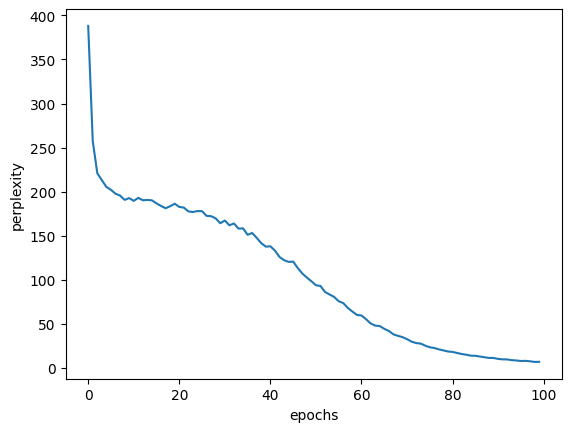

In [8]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch05/train_custom_loop.py
License: MIT License
Accessed: 2024-11-21

Modified to work on jupyter notebook
------------------------------------------------------------
"""

# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from optimizer import SGD
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

""" 1번 부분 시작 """
# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size              # 미니배치 크기만큼 점프 할 크기 계산
offsets = [i * jump for i in range(batch_size)]     # 미니배치 별로 시작하는 데이터의 offset
""" 1번 부분 끝 """


for epoch in range(max_epoch):
    for iter in range(max_iters):
        
        """ 2번 부분 시작 """
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')      # batch_size x time_size의 행렬
        batch_t = np.empty((batch_size, time_size), dtype='i')      # batch_size x time_size의 행렬
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        """ 2번 부분 끝 """


        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    """ 3번 부분 시작 """
    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
    """ 3번 부분 끝 """

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

코드의 2번 부분에 대한 좀 더 자세한 사항은 다음과 같다.

<img src="./img/memo-5-3-3-batch-data.jpg">